In [4]:
# when not using colab
import sys
sys.path.append('src/QA')
import reload_recursive

In [6]:
%reload word_embed
from word_embed import WordEmbed

In [7]:
%reload data_prep
from data_prep import DataPrep

In [8]:
import pickle

In [20]:
results = pickle.load(open("models/results.pkl", "rb"))

In [21]:
# find the best model on the results given
# chooses the highest seen test f1 score
def get_best_model(results):
    best_f1_seen = 0.0
    best_model = None
    best_model_it = None
    for key, value in results.items():
        for it, model_results in value.items():
            model_f1 = model_results["test_report"]["1"]["f1-score"]
            if model_f1 > best_f1_seen:
                best_f1_seen = model_f1
                best_model = {key: value}
                best_model_it = it
    
    return best_f1_seen, best_model, best_model_it

In [22]:
best_f1_seen, best_model, best_model_it = get_best_model(results)

In [23]:
def get_keys_from_model(model):
    return dict(list(model.items())[0][0])

In [24]:
best_model_params = get_keys_from_model(best_model)

In [25]:
def remove_param(param, name):
    cut_param = dict(param)
    del cut_param[name]
    return cut_param

In [27]:
%reload model
import model
from model.results_helpers import ResultsHelper

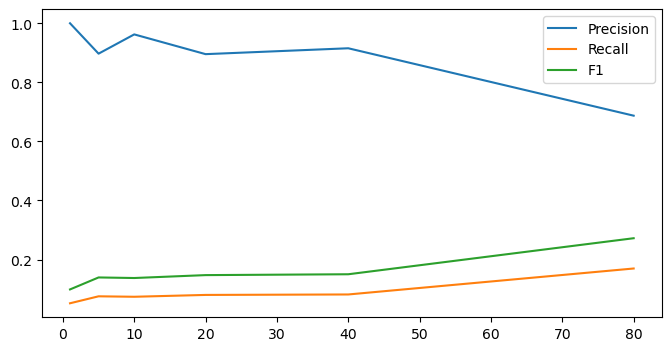

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
ResultsHelper.plot_metrics_over_its(best_model, train=False)
plt.legend()
plt.show()

## Best RNN models with 1 hidden layer

In [399]:
best_rnn_1_layer_model = get_best_model(ResultsHelper.get_matching_models({"hidden_type": "RNN", "doc_hidden_layers": 1}, results))[1]

In [400]:
best_rnn_1_layer_model_params = get_keys_from_model(best_rnn_1_layer_model)
rnn_1_layer_vary_attention_type = remove_param(best_rnn_1_layer_model_params, "attention_type")

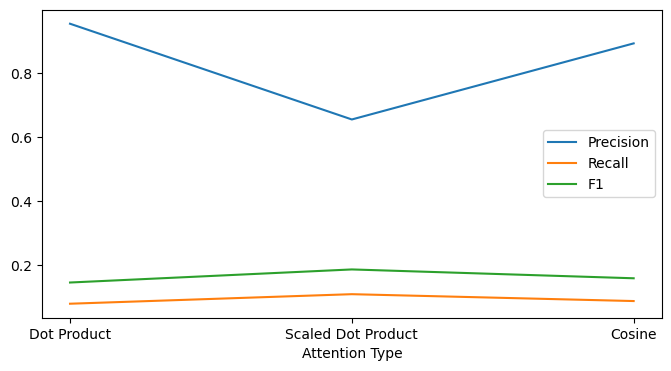

In [401]:
bm_without_attention_type = remove_param(best_model_params, "attention_type")
plt.figure(figsize=(8,4))
ResultsHelper.plot_metrics_for_one_it(ResultsHelper.get_matching_models(bm_without_attention_type, results), var_X = "attention_type", var_X_pretty_name = "Attention Type", it=40, train=False)
plt.legend()
plt.show()

## Examine doc lengths

In [191]:
train_q_inputs, train_doc_inputs, train_doc_targets = DataPrep.tokenize_json(DataPrep.convert_pd_to_json(DataPrep.parse_tsv('WikiQA-train.tsv')))
test_q_inputs, test_doc_inputs, test_doc_targets = DataPrep.tokenize_json(DataPrep.convert_pd_to_json(DataPrep.parse_tsv('WikiQA-test.tsv')))

In [209]:
train_doc_full = [[tok for sentence in doc for tok in sentence] for doc in train_doc_inputs]
test_doc_full = [[tok for sentence in doc for tok in sentence] for doc in test_doc_inputs]

In [213]:
train_doc_lens = [len(doc) for doc in train_doc_full]
test_doc_lens = [len(doc) for doc in test_doc_full]

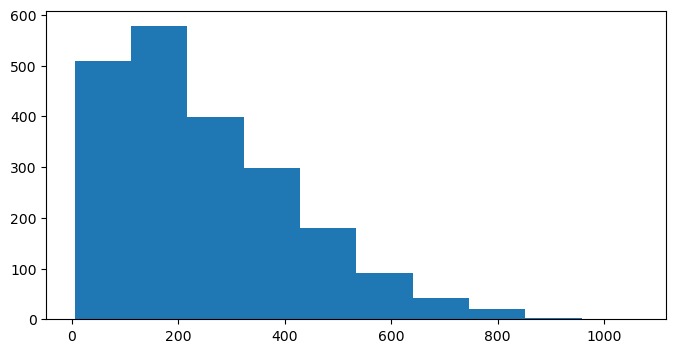

In [217]:
plt.figure(figsize=(8,4))
plt.hist(train_doc_lens)
plt.show()

In [239]:
models_large_its = ResultsHelper.get_matching_models({'iters_inc': (1, 4, 5, 10, 20, 40, 80)}, results)

## Best model ablations

In [273]:
best_model_params

{'doc_hidden_layers': 2,
 'iters_inc': (1, 4, 5, 10, 20, 40),
 'doc_cut_size': 256,
 'doc_with_ner': True,
 'answer_type': 'Out_And_In',
 'q_with_pos': True,
 'q_with_ner': False,
 'bidirectional': False,
 'attention_type': 'Dot Product',
 'learning_rate': 0.1,
 'doc_with_tfidf': False,
 'doc_with_pos': False,
 'batch': 128,
 'befaft': False,
 'q_cut_size': 'Max',
 'hidden_size': 100,
 'doc_with_wm': False,
 'hidden_type': 'GRU'}

In [275]:
best_model_it

80

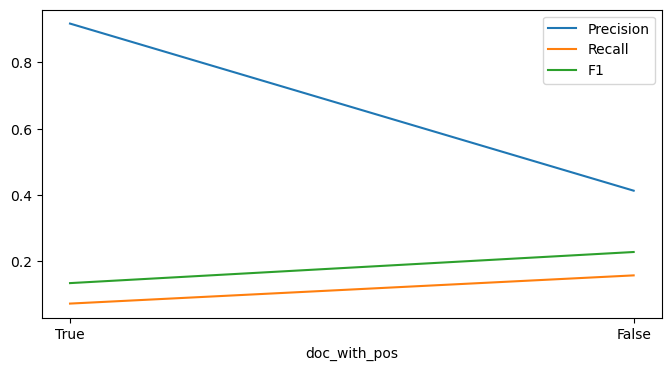

In [300]:
bm_ablate_doc_with_pos_params = remove_param(best_model_params, "doc_with_pos")
plt.figure(figsize=(8,4))
ResultsHelper.plot_metrics_for_one_it(ResultsHelper.get_matching_models(bm_ablate_doc_with_pos_params, results), var_X = "doc_with_pos", it = 80, train=False)
plt.legend()
plt.show()

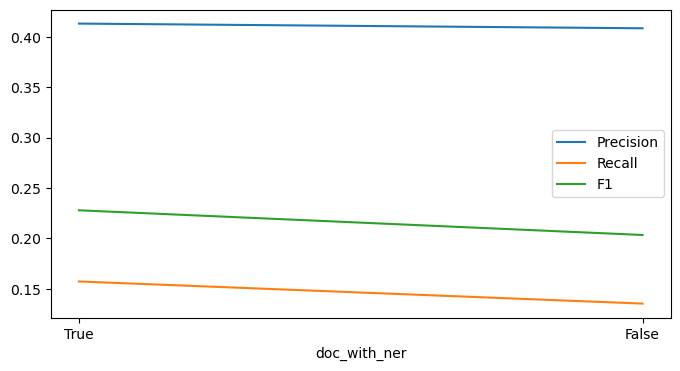

In [299]:
bm_ablate_doc_with_ner_params = remove_param(best_model_params, "doc_with_ner")
plt.figure(figsize=(8,4))
ResultsHelper.plot_metrics_for_one_it(ResultsHelper.get_matching_models(bm_ablate_doc_with_ner_params, results), var_X = "doc_with_ner", it = 80, train=False)
plt.legend()
plt.show()

In [331]:
bm_only_glove = best_model_params.copy()
bm_only_glove["doc_with_ner"] = False
bm_only_glove["q_with_pos"] = False
bm_only_glove["q_with_ner"] = False
bm_only_glove_model = ResultsHelper.get_matching_models(bm_only_glove, results)

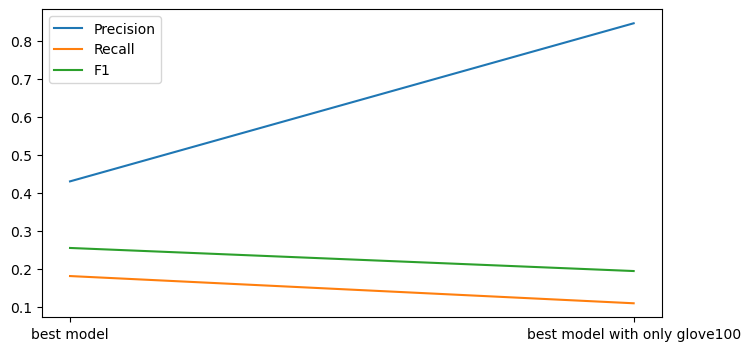

In [351]:
plt.figure(figsize=(8,4))
ResultsHelper.plot_comparison_metrics_on_one_it(best_model, bm_only_glove_model, it=80)
plt.legend()
plt.xticks([0,1], ["best model", "best model with only glove100"])
plt.show()

In [346]:
bm_all_embeds = best_model_params.copy()
bm_all_embeds["q_with_ner"] = True
bm_all_embeds["doc_with_tfidf"] = True
bm_all_embeds["doc_with_pos"] = True
bm_all_embeds["doc_with_wm"] = True
bm_all_embeds_model = ResultsHelper.get_matching_models(bm_all_embeds, results)

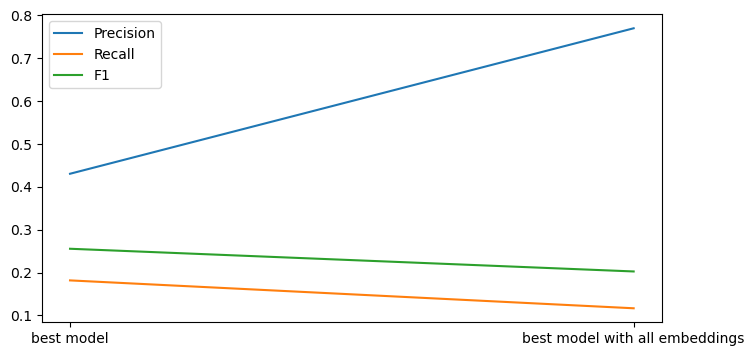

In [350]:
plt.figure(figsize=(8,4))
ResultsHelper.plot_comparison_metrics_on_one_it(best_model, bm_all_embeds_model, it=80, train=False)
plt.legend()
plt.xticks([0,1], ["best model", "best model with all embeddings"])
plt.show()

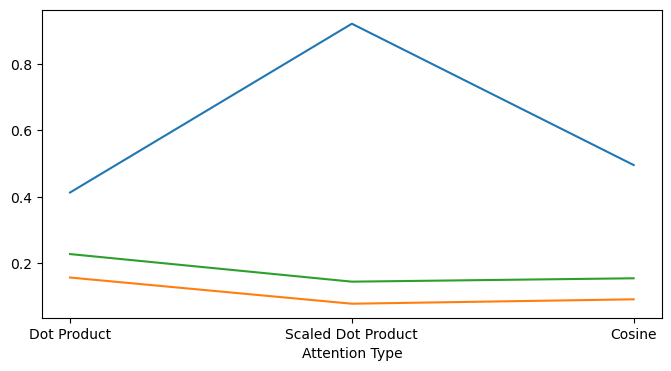

In [376]:
bm_attention_ablations = remove_param(best_model_params, "attention_type")
plt.figure(figsize=(8,4))
ResultsHelper.plot_metrics_for_one_it(ResultsHelper.get_matching_models(bm_attention_ablations, results), var_X="attention_type", var_X_pretty_name="Attention Type", it=80, train=False)
plt.show()

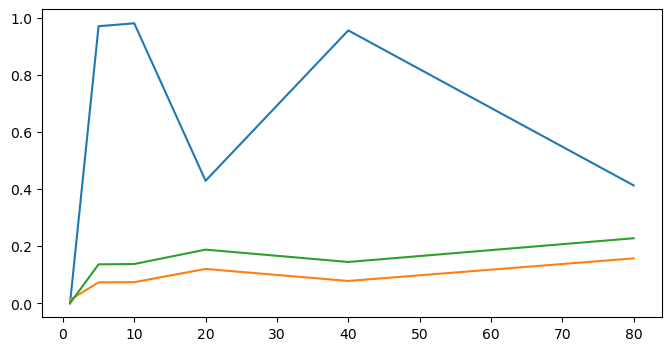

In [357]:
plt.figure(figsize=(8,4))
ResultsHelper.plot_metrics_over_its(best_model, train=False)
plt.show()

In [402]:
bm_max_doc_len_param = best_model_params.copy()
bm_max_doc_len_param["doc_cut_size"] = "Max"
bm_max_doc_len_model = ResultsHelper.get_matching_models(bm_max_doc_len_param, results)

In [410]:
best_model_params

{'doc_hidden_layers': 2,
 'iters_inc': (1, 4, 5, 10, 20, 40),
 'doc_cut_size': 256,
 'doc_with_ner': True,
 'q_with_pos': True,
 'answer_type': 'Out_And_In',
 'q_with_ner': False,
 'bidirectional': False,
 'attention_type': 'Dot Product',
 'learning_rate': 0.1,
 'doc_with_tfidf': False,
 'doc_with_pos': False,
 'batch': 128,
 'befaft': False,
 'q_cut_size': 'Max',
 'hidden_size': 100,
 'doc_with_wm': False,
 'hidden_type': 'GRU'}

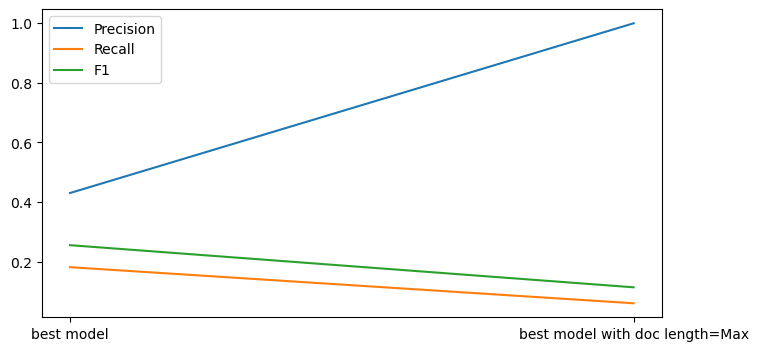

In [409]:
plt.figure(figsize=(8,4))
ResultsHelper.plot_comparison_metrics_on_one_it(best_model, bm_max_doc_len_model, it=80, train=False)
plt.legend()
plt.xticks([0,1], ["best model", "best model with doc length=Max"])
plt.show()